<a href="https://colab.research.google.com/github/dIcarusb/Master_project/blob/master/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UNET model

Importing libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers.merge import *
from numpy.random import shuffle
from numpy.random import seed
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

Using TensorFlow backend.


## Loading the dataset

In [0]:
from google.colab import files

uploaded = files.upload()

In [0]:
y = np.load('y.npy')
x = np.load('x.npy')

Transforming "y" into 3 classes/3 dimensiones, with the help of dummy function:

In [0]:
def dummy(y):
  NewY = np.zeros(448*120*120*3)
  Y = np.reshape(NewY, (448,120,120,3))
  
  for i in range(0,447):
    for j in range(0,119):
      for k in range(0,119):
        if y[i][j][k]==0:
          Y[i][j][k][0]=1
        elif y[i][j][k]==128:
          Y[i][j][k][1]=1
        else:
          Y[i][j][k][2]=1
        
  return(Y)

In [0]:
y = dummy(y)

"x" scaling

In [0]:
x = x/255

Random shuffle

In [0]:
seed(2)
shuffle(x)
seed(2)
shuffle(y)

Test and train partition

In [0]:
X_test = x[418:]
Y_test = y[418:]
X_train = x[0:417]
Y_train= y[0:417]

## Model

In [0]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="glorot_uniform"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=2, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters, size=size)
    return y

def Unet(img_height, img_width, nclasses=3, filters=64):
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    
    # down
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(3, 3))(conv4)
    conv5 = conv_block(conv4_out,  nfilters=filters*16)
    
    # up
    deconv6 = deconv_block(conv5, residual=conv4,  nfilters=filters*8, strides=(3,3))
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2, size=3)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    
    # "U" shape
    
    # output
    output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9)
    output_laye = Dropout(0.5)(output_layer)
    output_layer = Activation('softmax')(output_layer)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model
  
  

Building the model

In [0]:
m = Unet(120, 120, nclasses=3, filters=64)
m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 120, 64) 1792        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 120, 120, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 120, 120, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## Training the model

In [0]:
start=time.time()
history = m.fit(X_train, Y_train,epochs=30, batch_size=20, verbose=1, validation_data=(X_test, Y_test))
end=time.time()
print("Time:")
print(end-start)

Train on 417 samples, validate on 30 samples
Epoch 1/30
417/417 [==============================] - 30s 73ms/step - loss: 0.4885 - acc: 0.7988 - val_loss: 0.3107 - val_acc: 0.9025
Epoch 2/30
417/417 [==============================] - 15s 36ms/step - loss: 0.1911 - acc: 0.9509 - val_loss: 0.1749 - val_acc: 0.9576
Epoch 3/30
417/417 [==============================] - 15s 36ms/step - loss: 0.1217 - acc: 0.9735 - val_loss: 0.1707 - val_acc: 0.9599
Epoch 4/30
417/417 [==============================] - 15s 37ms/step - loss: 0.0980 - acc: 0.9780 - val_loss: 0.1123 - val_acc: 0.9761
Epoch 5/30
417/417 [==============================] - 15s 36ms/step - loss: 0.0803 - acc: 0.9830 - val_loss: 0.0971 - val_acc: 0.9811
Epoch 6/30
417/417 [==============================] - 15s 36ms/step - loss: 0.0716 - acc: 0.9850 - val_loss: 0.0969 - val_acc: 0.9799
Epoch 7/30
417/417 [==============================] - 15s 37ms/step - loss: 0.0675 - acc: 0.9857 - val_loss: 0.0765 - val_acc: 0.9847
Epoch 8/30
417/41

## Evaluation of the model

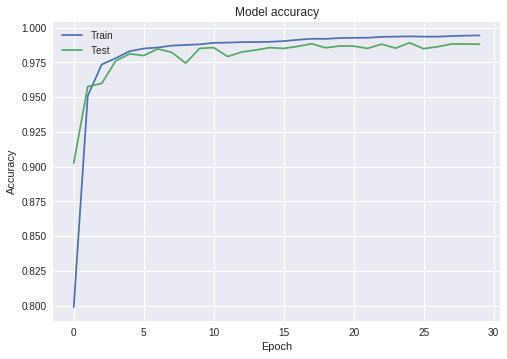

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Unet_accuracy.png')
plt.show()

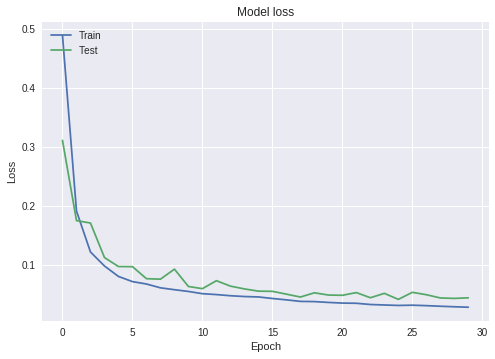

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Unet_loss.png')
plt.show()

Accuracy on test data

In [0]:
score = m.evaluate(X_test, Y_test)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

30/30 [==============================] - 2s 82ms/step

Test loss: 0.04413395747542381
Test accuracy: 0.9880316257476807


Prediction on test data

In [0]:
prediction = m.predict(X_test,verbose=1)
p = np.reshape(prediction, (30,120,120,3))
p = p.round()

30/30 [==============================] - 1s 23ms/step


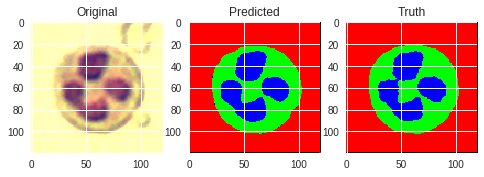

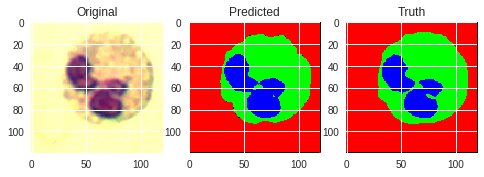

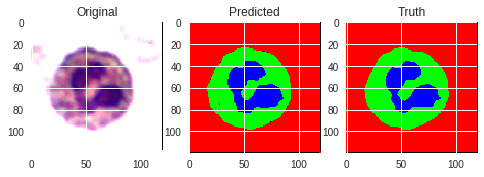

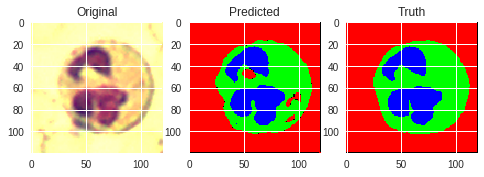

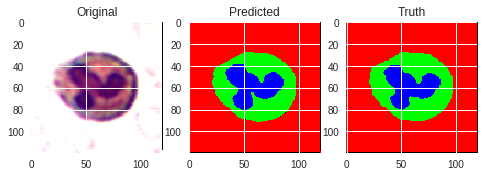

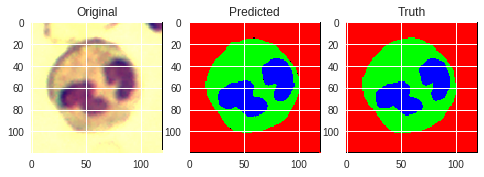

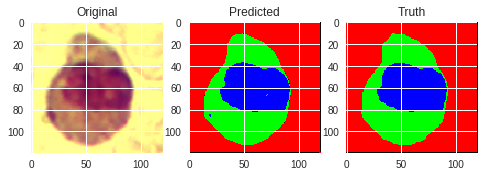

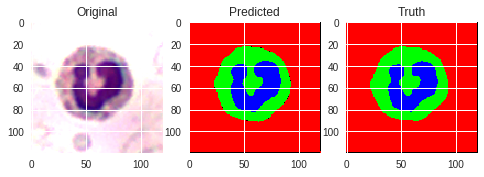

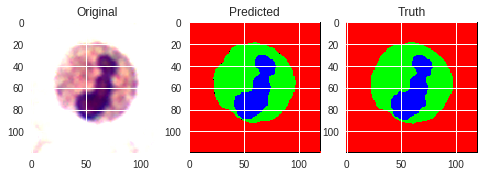

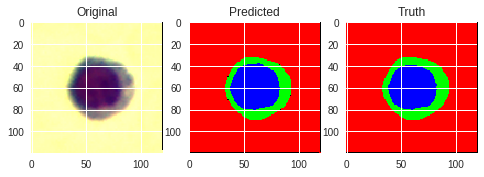

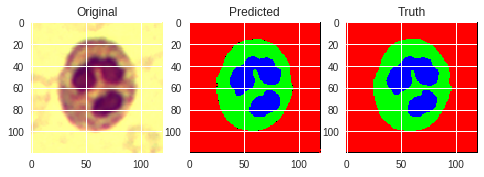

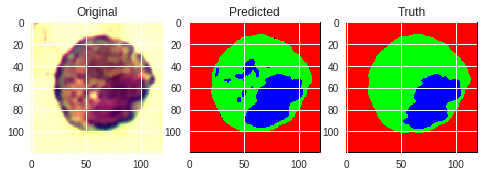

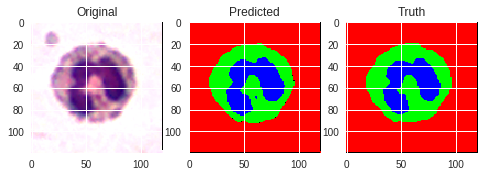

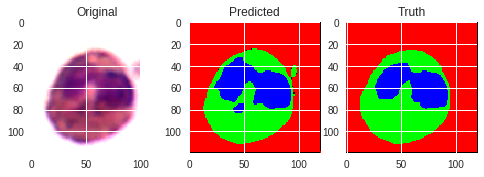

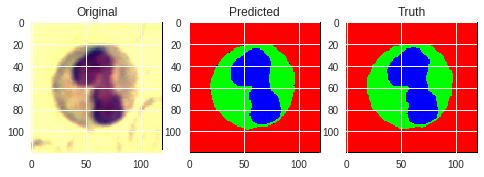

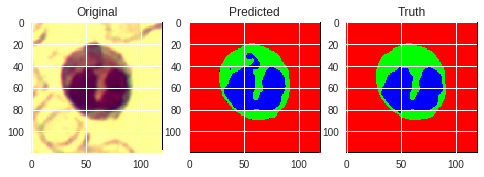

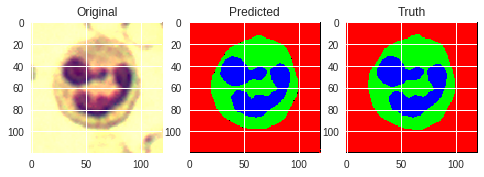

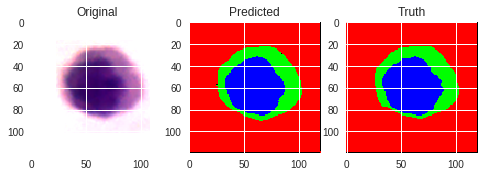

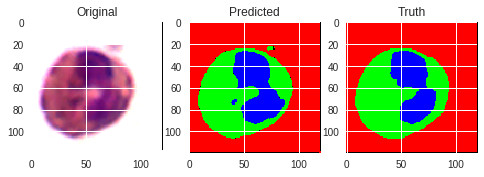

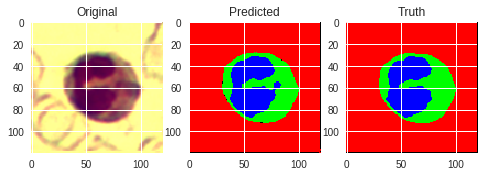

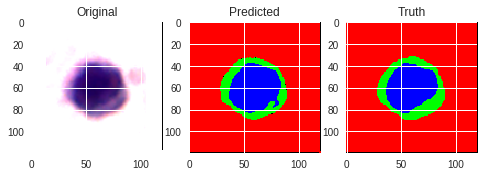

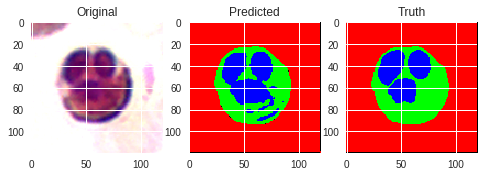

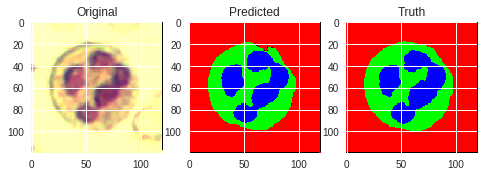

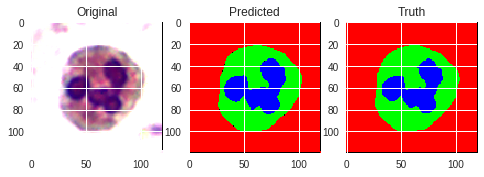

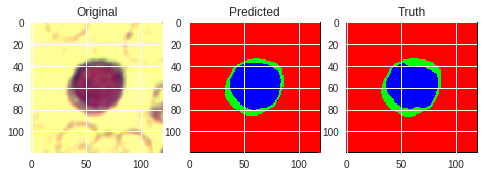

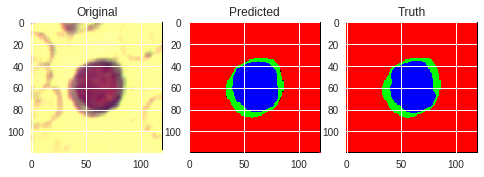

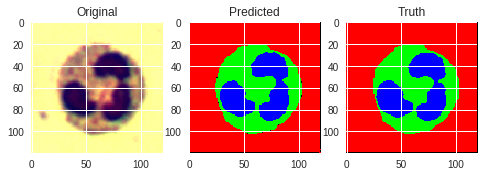

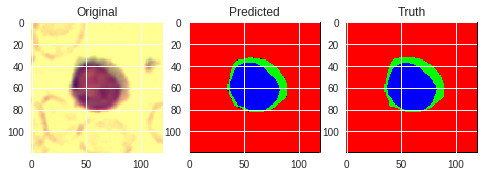

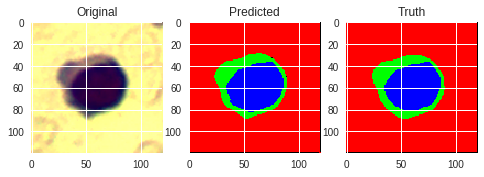

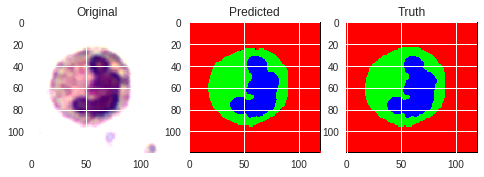

In [0]:
for i in range(30):
  fig = plt.figure()
  a=fig.add_subplot(1,3,1)
  plt.imshow(X_test[i])
  a.set_title('Original')
  a=fig.add_subplot(1,3,2)
  plt.imshow(p[i])
  a.set_title('Predicted')
  a=fig.add_subplot(1,3,3)
  plt.imshow(Y_test[i])
  a.set_title('Truth')
  plt.show()

Jaccard similarity

In [0]:
y_true = np.reshape(Y_test, (30, 3, 120*120))
y_pred = np.reshape(p, (30, 3, 120*120))

cyto = []
nucl = []

for i in range(30):
  print(i)
  print("cytoplasm similarity:")
  jac = jaccard_similarity_score(y_true[i][1], y_pred[i][1])
  cyto.append(jac)
  print(jac)
  print("nucleus similarity:")
  jac = jaccard_similarity_score(y_true[i][2], y_pred[i][2])
  nucl.append(jac)
  print(jac)

0
cytoplasm similarity:
0.9838888888888889
nucleus similarity:
0.9927083333333333
1
cytoplasm similarity:
0.9815972222222222
nucleus similarity:
0.9941666666666666
2
cytoplasm similarity:
0.984375
nucleus similarity:
0.9957638888888889
3
cytoplasm similarity:
0.9586805555555555
nucleus similarity:
0.9810416666666667
4
cytoplasm similarity:
0.9832638888888889
nucleus similarity:
0.9947222222222222
5
cytoplasm similarity:
0.9788888888888889
nucleus similarity:
0.9888194444444445
6
cytoplasm similarity:
0.9927777777777778
nucleus similarity:
0.9950694444444445
7
cytoplasm similarity:
0.9838888888888889
nucleus similarity:
0.9957638888888889
8
cytoplasm similarity:
0.9908333333333333
nucleus similarity:
0.9947916666666666
9
cytoplasm similarity:
0.9828472222222222
nucleus similarity:
0.998125
10
cytoplasm similarity:
0.9825694444444445
nucleus similarity:
0.9932638888888888
11
cytoplasm similarity:
0.9543055555555555
nucleus similarity:
0.9788888888888889
12
cytoplasm similarity:
0.9863194

In [0]:
m = np.array(cyto).mean()
s = np.array(cyto).std()
print("cytoplasm jaccard index mean:", m.round(8) , "+/-", (s/np.sqrt(30)).round(8))
m = np.array(nucl).mean()
s = np.array(nucl).std()
print("nucleus jaccard index mean:", m.round(8) , "+/-", (s/np.sqrt(30)).round(8))

cytoplasm jaccard index mean: 0.98022454 +/- 0.00200355
nucleus jaccard index mean: 0.99240972 +/- 0.00088276


Dice Similarity Coefficient

In [0]:
cyto = []
nucl = []

for i in range(30):
  print(i)
  print("cytoplasm similarity:")
  f1 = f1_score(y_true[i][1], y_pred[i][1], average='binary')
  cyto.append(f1)
  print(f1)
  print("nucleus similarity:")
  f1 = f1_score(y_true[i][2], y_pred[i][2], average='binary')
  nucl.append(f1)
  print(f1)

0
cytoplasm similarity:
0.9756200084068937
nucleus similarity:
0.9886865639478505
1
cytoplasm similarity:
0.9721433827394093
nucleus similarity:
0.9909502262443439
2
cytoplasm similarity:
0.9763580960386675
nucleus similarity:
0.9934288484326188
3
cytoplasm similarity:
0.9373750131565098
nucleus similarity:
0.9705723833135712
4
cytoplasm similarity:
0.9746768939791952
nucleus similarity:
0.9918103448275862
5
cytoplasm similarity:
0.9680605169153184
nucleus similarity:
0.982656468813961
6
cytoplasm similarity:
0.9890687408030272
nucleus similarity:
0.9923516104707529
7
cytoplasm similarity:
0.975609756097561
nucleus similarity:
0.9934274323887513
8
cytoplasm similarity:
0.9861315402395462
nucleus similarity:
0.9919207152860068
9
cytoplasm similarity:
0.9740464432068929
nucleus similarity:
0.9970914575029625
10
cytoplasm similarity:
0.973620599054125
nucleus similarity:
0.9895507917699019
11
cytoplasm similarity:
0.9308678293759194
nucleus similarity:
0.9672484378366731
12
cytoplasm simi

In [0]:
m = np.array(cyto).mean()
s = np.array(cyto).std()
print("cytoplasm Dice Similarity Coefficient mean:", m.round(8) , "+/-", (s/np.sqrt(30)).round(8))
m = np.array(nucl).mean()
s = np.array(nucl).std()
print("nucleus Dice Similarity Coefficient mean:", m.round(8) , "+/-", (s/np.sqrt(30)).round(8))

cytoplasm Dice Similarity Coefficient mean: 0.97007248 +/- 0.00303288
nucleus Dice Similarity Coefficient mean: 0.98822427 +/- 0.00136976
